#### Image Augmentation
The data preprocessing pipeline is explained in the main notebook, but here I would like to show the difference using the ImageDataAugmentation can really make to the accuracy of the network

In [1]:
import pickle
import numpy as np
import pandas as pd
import cv2
from sklearn.utils import class_weight
from scipy.misc import imread, imsave

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_style("whitegrid")

In [13]:
from keras.models import Sequential, Model,load_model
from keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, MaxPooling2D, Input
from keras import utils
from keras.callbacks import Callback, LambdaCallback, EarlyStopping, ModelCheckpoint
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta, Adam
from keras import backend as K
from keras.preprocessing import image
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [4]:
# please refer to the main notebook about the histogram normalisation process-- here I am loading the 
# normalised data to show the difference the image augmentation makes
X_train_hist_norm1 =np.load('data/X_train_hist_norm1.npy')
X_valid_hist_norm1 =np.load('data/X_valid_hist_norm1.npy')
X_test_hist_norm1 = np.load('data/X_test_hist_norm1.npy')

y_train_cat =np.load('data/y_train_cat.npy')
y_valid_cat =np.load('data/y_valid_cat.npy')
y_test_cat = np.load('data/y_ttest_cat.npy')

hist_norm_values = np.load('data/mean_hist_values.npy').item()

datagen = image.ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    rotation_range=10.)

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


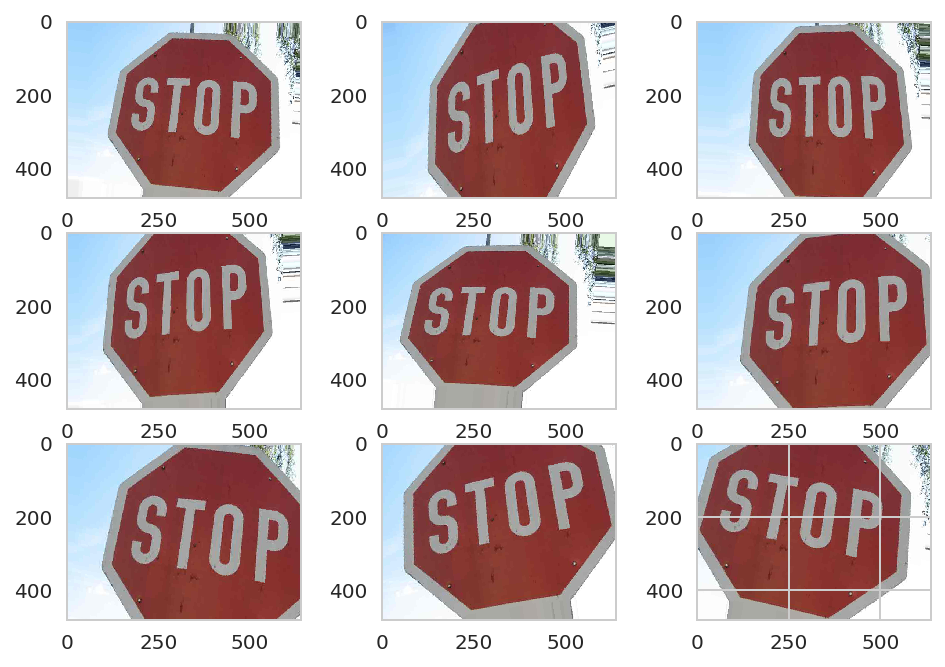

In [5]:
# a quick look at what the datagen does (here, I am not using the rest of the image preprocessing pipeline so as to simplify what the datagenerator does)
test_img =imread('data/traffic_sign14.jpg')
i = 0
for batch in datagen.flow(np.array([test_img]), batch_size=1):
    plt.grid(False)
    plt.subplot(3,3,i+1)
    plt.imshow(np.squeeze(batch).astype(np.uint8) )
    i += 1
    if i > 8:
        break

In [6]:
def logger(epoch, logs):
    if epoch %2== 0: 
        print(epoch, logs['loss'], logs['acc'], logs['val_acc'])
logging_callback = LambdaCallback(
    on_epoch_end=logger)


In [11]:
# vgg model for testing augmented training vs non augmented trainings
def vggLike(n_classes, ksize=(3,3), dropout=0.25):
    inputs = Input(shape=(32,32,3))
    
    block1 = Conv2D(32, kernel_size=ksize, activation='relu', padding='same', name='set1_conv1')(inputs)
    block1 = BatchNormalization()(block1)
    block1 = Conv2D(32, kernel_size=ksize, activation='relu', padding='same', name='set1_conv2')(block1)
    block1 = BatchNormalization()(block1)
    block1 = MaxPooling2D(pool_size=(2, 2),strides=(2, 2), name='set1_pool')(block1)
    
    block2 = Conv2D(64, kernel_size=ksize, activation='relu', padding='same', name='set2_conv1')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Conv2D(64, kernel_size=ksize, activation='relu', padding='same', name='set2_conv2')(block2)
    block2 = BatchNormalization()(block2)
    block2 = Conv2D(64, kernel_size=ksize, activation='relu', padding='same', name='set2_conv3')(block2)
    block2 = BatchNormalization()(block2)
    block2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2),name='set2_pool')(block2)
    output2 = Flatten()(block2)
        
    fcblock = Dense(1024, activation='relu', name='fc1')(output2)
    fcblock = BatchNormalization()(fcblock)
    fcblock = Dropout(dropout)(fcblock)
    fcblock = Dense(512, activation='relu' , name='fc2')(fcblock)
    fcblock = BatchNormalization()(fcblock)
    fcblock = Dropout(dropout)(fcblock)  
    predictions = Dense(n_classes, activation='softmax', name='final')(fcblock)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    return model
    

In [14]:
# without image augmentation
K.clear_session()
batch_size = 32
epochs = 20
n_classes = 43
vgg_model = vggLike(n_classes)

vgghistory_no_augment = vgg_model.fit(X_train_hist_norm1, y_train_cat, batch_size=batch_size,
                    epochs=epochs,
                      verbose=0,
                    validation_data=(X_valid_hist_norm1, y_valid_cat),
                    callbacks=[logging_callback,
                               ModelCheckpoint('models/vgglike_no_img_augment.h5', save_best_only=True)
                              ])

0 0.406667815581 0.885054168251 0.946031746248
2 0.0456605186395 0.985976608551 0.945578231887
4 0.03374595118 0.989396247046 0.96462585034
6 0.0303582225243 0.991235380354 0.973469387755
8 0.0176638088567 0.99497111986 0.948979591837
10 0.0149759115036 0.995603321935 0.970975056689
12 0.015463162372 0.995459639672 0.979591836735
14 0.0117009649669 0.996810253168 0.978911564626
16 0.0122408787474 0.996494152131 0.972562358277
18 0.00996022191939 0.997126354206 0.966439909486


In [16]:
vgg_no_augment_model = load_model('models/vgglike_no_img_augment.h5')
# validation score
vgg_score_validation = vgg_no_augment_model.evaluate(X_valid_hist_norm1, y_valid_cat, verbose=0)
print(vgg_no_augment_model.metrics_names[0] + ": "+ str(vgg_score_validation[0]) + "," + vgg_no_augment_model.metrics_names[1] + ": " 
      +  str(vgg_score_validation[1]))

loss: 0.0747285770244,acc: 0.982766439909


In [17]:
# test score
vgg_score_test = vgg_no_augment_model.evaluate(X_test_hist_norm1, y_test_cat, verbose=0)
print(vgg_model.metrics_names[0] + ": "+ str(vgg_score_test[0]) + "," + vgg_no_augment_model.metrics_names[1] + ": " 
      +  str(vgg_score_test[1]))

loss: 0.127658291903,acc: 0.975613618416


In [18]:
# with image augmentation
K.clear_session()
vgg_model_augmented = vggLike(n_classes)

vgghistory_augmented = vgg_model_augmented.fit_generator(datagen.flow(X_train_hist_norm1, y_train_cat, batch_size=batch_size),
                    steps_per_epoch=X_train_hist_norm1.shape[0],
                    epochs=epochs,
                      verbose=0,
                    validation_data=(X_valid_hist_norm1, y_valid_cat),
                    callbacks=[logging_callback,
                               ModelCheckpoint('models/vgglike_augmented.h5', save_best_only=True)
                              ])

0 1.04017036446 0.696313112453 0.917233560091
2 0.167582290772 0.946722606999 0.938548753024
4 0.109111438648 0.965257622345 0.983446712018
6 0.0998385322284 0.969395672317 0.96462585034
8 0.0700870493805 0.977729245122 0.965759637377
10 0.0641738968183 0.980746573177 0.989795918367
12 0.0542890688335 0.983246645019 0.992063492063
14 0.0413899478354 0.987442167878 0.980272108844
16 0.0390797928188 0.988218052243 0.945804988662
18 0.0365773816863 0.988045633523 0.995011337868


In [19]:
vgg_augment_model = load_model('models/vgglike_augmented.h5')
# validation score
vgg_score_validation = vgg_augment_model.evaluate(X_valid_hist_norm1, y_valid_cat, verbose=0)
print(vgg_augment_model.metrics_names[0] + ": "+ str(vgg_score_validation[0]) + "," + vgg_augment_model.metrics_names[1] + ": " 
      +  str(vgg_score_validation[1]))

loss: 0.0182373660707,acc: 0.995011337868


In [20]:
# test score
vgg_score_test = vgg_augment_model.evaluate(X_test_hist_norm1, y_test_cat, verbose=0)
print(vgg_augment_model.metrics_names[0] + ": "+ str(vgg_score_test[0]) + "," + vgg_augment_model.metrics_names[1] + ": " 
      +  str(vgg_score_test[1]))

loss: 0.0847821132815,acc: 0.980918448158
